<a href="https://colab.research.google.com/github/credwood/VPN_Feature_Data/blob/main/VPN_Feature_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary

This colab is a direct continuation of [Kissane et al.'s](https://colab.research.google.com/drive/10zBOdozYR2Aq2yV9xKs-csBH2olaFnsq?usp=sharing) notebook and their methodologies explored in [the paper](https://arxiv.org/pdf/2406.17759) for sparse feature exploration of an attention SAE trained on the `gelu-2l` model's second layer `z` vector—the result of the attention pattern and the value vector operation, before the final linear `out` transformation. They outline different feature categories for this model, including local context features which fire on limited portions of larger text.

In the week I spent both [randomly and methodologically sorting through features](https://docs.google.com/document/d/1QsrGM4u5jN-lZ_iQJkxxUaJ79j0yf8HAf7Cg-CqWyUM/edit?usp=sharing) using their visualization tool, I came across two local context features which seemed to be activating in similar ways but for different verbs, bellow is an image of the top activations for one of those features (`feature 274`). The first feature fired on prepositional noun phrases of the form to + noun phrase for the verb listen, the other feature (`feature 212`) fired in a similar fashion but for the verb get. I noticed a small amount of polysemantic behavior with the get feature; it mostly fires on prepositional noun phrases, but occasionally on infinitive forms of verbs. I didn't notice this with the listen feature. I decided to explore the spectrum of these features, figuring that other verbs might have these features and that they might lie on a monosemantic/polysemantic continuum.

My interest in this potential feature family is influenced in spirit by [Michaud et al.'s](https://arxiv.org/pdf/2303.13506) exploration of scaling laws for language model capabilities.

My plan was to search for as many of these features as possible and to—for now qualitatively—assess their monosemanticity. To collect them, I defined a `verb+to+(optional article/adj)+noun` (sometimes abbreviated as VPN) grammar and used the Spacy part-of-speech tagger to find the data examples that have this construction. I stored the extracted VPN clauses and their location in the string.

To find the features that fire locally on these VPN clauses, I used a noisy heuristic of the difference between the **average** activation of tokens in the clause (sans the verb) and the **average** activation of the rest of the tokens. (More detail on this method in the feature finding section.)

I ended up sorting through collected features for 269 verbs, finding that:
1.  The more common a verb is in this  dataset (which was filtered for the grammar), the more likely it has a monosemantic feature.
2. As verb frequency decreases, polysemanticity with related verbs (e.g. correspond, relate and pertain all share a feature) increases; my total inability to find specific features increases too.
4. Many of the verbs without a found feature were present in primarily coding contexts.

Plotting the frequency and feature occurrences of the 50 most common verbs colored by feature presence and type appears to show a power law distribution, but more data both for more verbs and using a less noisy metric is certainly needed to fill in the picture.

I also run Direct Feature Attribution calculations and Direct Feature Attribution per source token calculations, but due to resource constraints I only run on a small subset of the total original training set.

This notebook is broken into five sections: Setup code which is necessary for all subsequent sections, three independent sections outlining the full process of this project, and a final 'next steps' section:

1. Grammar extraction: Code does not need to be run for the analysis sections, it's there for the sake of completion.

2. Feature collection: This code also does not need to be run for the analysis, it's there for the sake of completion.

3. Aggregate feature analysis: This code uses a pre-saved filtered dataset and labeled feature data which is local to the colab environment.

4. Individual feature analysis: Looking at the 'listen' `feature 274`.

5. Next steps: Potential next projects engendered by the early findings in this notebook



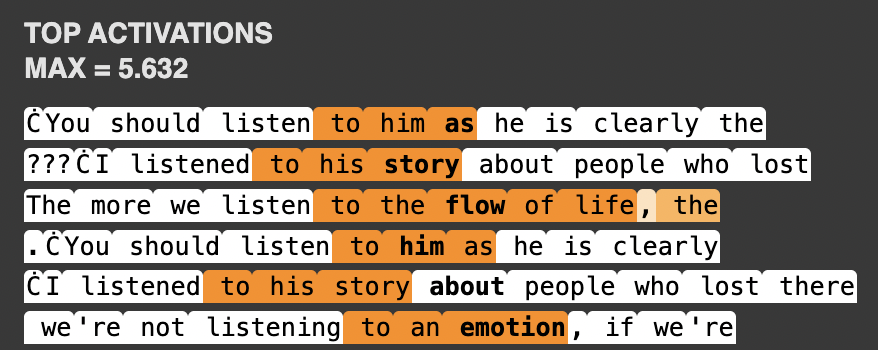

# Setup (imports, installs, data and model loading)

In [1]:
#@title Installations and environment setup
!wget https://github.com/callummcdougall/sae_visualizer/archive/refs/heads/main.zip
!unzip /content/main.zip

! git clone https://github.com/credwood/VPN_Feature_Data.git
!unzip /content/VPN_Feature_Data/tokenized_to_data.hf-20250101T203125Z-001.zip

from pathlib import Path

root = Path("sae_visualizer-main").rename("sae_visualizer")


%pip install transformer_lens
%pip install seaborn
%pip install plotly
%pip install git+https://github.com/callummcdougall/eindex.git


from IPython.display import display, HTML, clear_output
clear_output()


import os, sys
os.remove("/content/main.zip")
os.remove("/content/VPN_Feature_Data/tokenized_to_data.hf-20250101T203125Z-001.zip")
sys.path.append("/content/sae_visualizer")
sys.path.append("/content/tokenized_to_data.hf")


from transformer_lens import HookedTransformer, utils
import torch
from datasets import load_dataset, load_from_disk
from typing import Dict
from tqdm.notebook import tqdm
import plotly.express as px
import json
import pandas as pd
import numpy as np
from datasets import Dataset
import pprint

from sae_visualizer.model_fns import AutoEncoderConfig, AutoEncoder
from sae_visualizer.data_fns import get_feature_data, FeatureData

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False)

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

def imshow(x, **kwargs):
    x_numpy = utils.to_numpy(x)
    px.imshow(x_numpy, **kwargs).show()



In [2]:
#@title Autoencoder Architecture

from torch import nn
SAVE_DIR = Path("/workspace/1L-Sparse-Autoencoder/checkpoints")
# if not os.path.exists(SAVE_DIR):
#     os.makedirs(SAVE_DIR)
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["dict_size"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.cfg = cfg
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(cfg["act_size"], d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, cfg["act_size"], dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(cfg["act_size"], dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(cfg["device"])

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

    def get_version(self):
        version_list = [int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)]
        if len(version_list):
            return 1+max(version_list)
        else:
            return 0

    def save(self):
        version = self.get_version()
        torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
        with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
            json.dump(cfg, f)
        print("Saved as version", version)

    @classmethod
    def load(cls, version):
        cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
        return self

    @classmethod
    def load_from_hf(cls, version, device_override=None):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("ckkissane/tinystories-1M-SAES", f"{version}_cfg.json")
        if device_override is not None:
            cfg["device"] = device_override

        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("ckkissane/tinystories-1M-SAES", f"{version}.pt", force_is_torch=True))
        return self

In [3]:
#@title Additional imports
import time
import gzip
import json
import numpy as np
from pathlib import Path
from typing import List
from dataclasses import dataclass
from transformer_lens import utils, HookedTransformer
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import download_file_from_hf
import torch
from torch import Tensor
from eindex import eindex
from IPython.display import display, HTML
from typing import Optional, List, Dict, Callable, Tuple, Union, Literal
from dataclasses import dataclass
import torch.nn.functional as F
import einops
from jaxtyping import Float, Int
from collections import defaultdict
from functools import partial
from rich import print as rprint
from rich.table import Table
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sae_visualizer.utils_fns import sample_unique_indices, TopK, random_range_indices, reshape, to_str_tokens



In [4]:
#@title Feature search functions

valid_prepositions = ["to"]

def strip_verb(phrase):
    p = phrase.strip(" ")
    split = p.split(" ")
    assert split[1] in valid_prepositions, print(p.split(" "))
    len_verb = len(split[0]) if p[0] != " " else len(split[0]) + 1
    return " " + " ".join(split[1:]), len_verb

def estimate_token_indices(tokenized_full_string, start_char, end_char, tokenizer):

    full_string = tokenizer.decode(tokenized_full_string, skip_special_tokens = False)
    token_start = None
    token_end = None
    char_counter = 0
    num_tokens = len(tokenized_full_string)

    for i, token_id in enumerate(tokenized_full_string):
        token_text = tokenizer.decode([token_id])
        token_length = len(token_text)
        if start_char <= char_counter + token_length and token_start is None:
            token_start = i

        if end_char < char_counter + token_length and token_end is None:
            token_end = i + 1

        char_counter += token_length

        if token_start is not None and token_end is not None:
            break

    # Ensure the indices are within valid bounds
    token_start = max(0, token_start)
    token_end = min(num_tokens, token_end)

    return token_start, token_end


def find_complement(tensor, max_value):
    complement = []
    tensor = tensor.sort(dim=0)[0]

    start = 0
    if tensor[0, 0] > start:
        complement.append([start, tensor[0, 0] - 1])

    for i in range(1, len(tensor)):
        if tensor[i, 0] > tensor[i - 1, 1] + 1:
            complement.append([tensor[i - 1, 1] + 1, tensor[i, 0] - 1])

    end = max_value
    if tensor[-1, 1] < end:
        complement.append([tensor[-1, 1] + 1, end])

    return torch.tensor(complement)

# Adapted from [LINK TO ORIGINAL COLAB]
@torch.inference_mode()
def get_act_diff_for_substring(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "seq"],
    substring_data: List[Tuple[int, int]],
    act_delta: float = 1.0,
    verbose: bool = False,
):
    '''
    Args:
        substring_data: List[Tuple[int, int]]
            Substring and list of start and end indices for the substring in the record.
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch


    Returns list of features indices for which the substring tokens are max activations
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    all_tokens = tokens.unsqueeze(0) if len(tokens.shape) == 1 else tokens
    all_tokens = all_tokens.to(device)

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc
    feature_bias = encoder.b_enc
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        x_cent = act - encoder.b_dec
        feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    model.run_with_hooks(all_tokens, return_type=None, fwd_hooks=[
        (encoder.cfg["act_name"], hook_fn_act_post),
    ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    feat_acts = feat_acts.unsqueeze(0) if len(feat_acts.shape) == 1 else feat_acts
    assert feat_acts[:, :-1].shape == all_tokens[:, :-1].shape + (feature_act_dir.shape[-1],)

    substring_inds = []
    for start_char, end_char in substring_data["pointers"]:
        start_char, end_char = int(start_char), int(end_char)
        start, end = estimate_token_indices(all_tokens[0], start_char, end_char, model.tokenizer)
        substring_inds.append([start, end])

    feature_dict = defaultdict(list)

    act_diff = substring_activation_diff(all_tokens, feat_acts, substring_inds)
    act_diff = act_diff.squeeze(0)
    feature_inds = feature_inds = (act_diff > act_delta).nonzero().squeeze()
    values_over_delta = act_diff[feature_inds]
    feature_dict["feature_list"] = feature_inds.cpu().tolist()
    feature_dict["activation_diffs"] = values_over_delta.cpu().tolist()

    return feature_dict


def substring_activation_diff(tokens, feature_activations, substring_inds):
    indices = torch.tensor(substring_inds)
    indices_compliment = find_complement(indices, tokens.shape[1]-1)
    avg_act_substr = torch.stack([feature_activations[:, ind[0]:ind[1]+1, :].sum(dim=1)/(ind[1] - ind[0] + 1) for ind in indices],dim=1).mean(dim=1)
    avg_act_not_substr = torch.stack([feature_activations[:, ind[0]:ind[1]+1, :].sum(dim=1)/(ind[1] - ind[0] + 1) for ind in indices_compliment], dim=1).mean(dim=1)
    return avg_act_substr - avg_act_not_substr


In [5]:
#@title Load Autoencoder
auto_encoder_run = "concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"
encoder = AutoEncoder.load_from_hf(auto_encoder_run)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)096_dc1.00e-07_rie50000_nr4_v78_cfg.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

{'act_name': 'blocks.1.attn.hook_z',
 'act_size': 512,
 'anthropic_resample_last': 25000,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'concat_heads': True,
 'dead_direction_cutoff': 1e-07,
 'device': 'cuda',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'head': 'cat',
 'l1_coeff': 2.0,
 'layer': 1,
 'lr': 0.001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'name': 'gelu-2l_1_16384_z',
 'num_resamples': 4,
 'num_tokens': 2000000000,
 're_init_every': 50000,
 'reinit': 'reinit',
 'resample_factor': 0.01,
 'save_state_dict_every': 50000,
 'seed': 49,
 'seq_len': 128,
 'site': 'z',
 'wandb_entity': 'ckkissane',
 'wandb_project_name': 'concat-z-gelu-21-l1-lr-sweep-3'}


(…)84_bs4096_dc1.00e-07_rie50000_nr4_v78.pt:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

In [6]:
#@title load gelu-2l

cfg = AutoEncoderConfig()
model: HookedTransformer = HookedTransformer.from_pretrained("gelu-2l").to(cfg.dtype).to(device)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model gelu-2l into HookedTransformer
Changing model dtype to torch.float32
Moving model to device:  cuda


In [7]:
#@title load training corpus
data = load_dataset("NeelNanda/c4-code-20k", split="train")

README.md:   0%|          | 0.00/754 [00:00<?, ?B/s]

(…)-00000-of-00001-97684e149eb4d60d.parquet:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [8]:
#@title Tokenize training corpus for analysis below
tokenized = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized = tokenized.shuffle(seed=42)
all_tokens = tokenized["tokens"]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

In [9]:
#@title Load tokenized data filtered data
from datasets import load_from_disk
tokenized_data_preprocesses = load_from_disk("/content/tokenized_to_data.hf")

# VPN grammar extraction (for reference, no need to run in order to run the analysis cells)

I'm including this section for reference. This code takes about ten minutes to run—mostly because the functions are mapped to `Dataset` rows—so the analysis in this notebook uses a pre-prepaired grammar-extracted/filtered dataset.

In [10]:
#@title Grammar extraction functions
from typing import Any

import nltk
from nltk import pos_tag, word_tokenize
from nltk.chunk import RegexpParser
from transformers import AutoTokenizer
import re
import spacy

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets_json')


"""
other_prepositions = [
    "against", "along", "among", "around", "as", "except", "for", "from", "in",
    "inside", "into", "like", "near", "of", "off", "on", "onto", "out",
    "within", "without", "throughout", "till", "under", "underneath", "until",
    "up", "upon", "with", "about", "below", "beneath", "beside", "toward",
    "outside", "over", "past", "since",
    "above", "across", "after", "at", "before", "behind", "between",
    "beyond", "during", "through"
]
"""
# Define the grammar for valid_prepositions and require at least one noun

valid_prepositions = ["to"]

# verb + prep (in `valid_prepositions`) + optional adj/article + noun
grammar = r"""
    VP_NP: {<VERB.*><PREP>(?=.*<NOUN>)(<DET|ADJ.*|NOUN.*>+)}
"""

nlp = spacy.load('en_core_web_sm')
chunk_parser = RegexpParser(grammar)

def detect_vp_pp(record: List[int], tokenizer: AutoTokenizer) -> List[Dict[str, Any]]:
    """
    Detect verb-preposition-noun (VP + PP) phrases in a tokenized document.

    This function identifies VP + PP phrases from a tokenized document. It filters out
    numbers and symbols to reduce noise, replaces the SpaCy preposition tag with a custom
    tag for `valid_prepositions`, and detects phrases that match the desired structure.

    Args:
        record (List[int]): A tokenized document represented as a list of token IDs.
        tokenizer (Any): Hugging Face AutoTokenizer object.

    Returns:
        List[Dict[str, Any]]: A list of detected phrases with their l=index locations in the string.
            Each entry is a dictionary with:
                - "phrase" (str): The detected VP + PP phrase.
                - "pointers" (List[Tuple[int, int]]): The start and end indices of the phrase in the decoded text.
    """
    record = tokenizer.decode(record, skip_special_tokens = True)
    sentences = nlp(record)
    detected_phrases = []
    for sentence in sentences.sents:
        preprocessed_pos_tags = []
        for tup in sentence:
            token, tag = tup.text, tup.pos_
            if token in valid_prepositions and tag == "ADP":
                preprocessed_pos_tags.append((token, 'PREP'))
            elif re.match(r"^[A-Za-z]+$", token):
                preprocessed_pos_tags.append((token, tag))
            else:
                preprocessed_pos_tags.append((token, 'PROG'))

        chunks = chunk_parser.parse(preprocessed_pos_tags)

        for subtree in chunks.subtrees(filter=lambda t: t.label() == 'VP_NP'):
            phrase_words = [word for word, _ in subtree.leaves()]
            phrase_str = " ".join(phrase_words)

            if not phrase_str[0].isupper():
                phrase_str = " " + phrase_str  # Add leading space for lower-cased words

            pointers = [(match.start(), match.end()) for match in re.finditer(re.escape(phrase_str), record)]
            if len(pointers) == 0:
                continue

            detected_phrases.append({"phrase": phrase_str,
                                    "pointers": pointers,
                                    })
    return detected_phrases

# Function to process and filter a Hugging Face Dataset object
def filter_dataset(dataset, tokenizer, column="tokens"):
    """
    Filters and tokenizes a Dataset object, keeping records with detected grammars and
    extracting associated tokens for the grammar patterns.

    Args:
        dataset (Dataset): The Hugging Face Dataset object to process.
        text_column (str): The column in the dataset containing text data.

    Returns:
        Dataset: A filtered Dataset object with detected grammar phrases and locations included.
    """
    def process_record(record):
        verb_count = detect_vp_pp(record[column], tokenizer)
        return {"tokens": record[column], "matched_tokens": verb_count}

    # Apply processing
    processed_dataset = dataset.map(process_record, num_proc=16)

    # Filter records to keep only those with matched tokens
    filtered_dataset = processed_dataset.filter(lambda record: len(record["matched_tokens"]) > 0)
    return filtered_dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.


In [11]:
#@title Run grammar extraction and tokenization, creating `tokenized_data_verb_prep `
tokenized = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized = tokenized.shuffle(seed=42)
tokenized_data_new = filter_dataset(tokenized, model.tokenizer)
tokenized_data_verb_prep = tokenized_data_new.shuffle(seed=42)

Map (num_proc=16):   0%|          | 0/215402 [00:00<?, ? examples/s]

Filter:   0%|          | 0/215402 [00:00<?, ? examples/s]

In [12]:
#@title Save `tokenized_data_verb_prep`. The analysis below uses a saved dataset `tokenized_data`

tokenized_data_verb_prep.save_to_disk("tokenized_data_verb_prep_check.hf")

Saving the dataset (0/1 shards):   0%|          | 0/2174 [00:00<?, ? examples/s]

# Aggregate Feature Analysis

The grammar-extracted dataset consists of only data  records which have at least one clause of the form `verb + to + (optional adjective/article) + noun` (VPN clause). The dataset contains the full tokenized documents and a field `matched_tokens` which contains a dictionary with the full clause as a string and start/end pointers to its location in the text string.

The two features I found which appear to track 'to' prepositional noun phrases following 'listen' and 'get'—and their conjugations—are examples of local context features which [Kissane et al].(https://arxiv.org/pdf/2406.17759) describe. Aside from polysemanticity in lower activation levels, these 'to' features primarily fire on 'to' + nounal phrases following the respective verbs.

I used a noisy heuristic of the difference between the average activation of tokens in the VPN clause (sans the verb) and the average activation of the rest of the tokens. I took into account repeat occurrences of the clause in a single string, but importantly not occurrences of similarly constructed cases for the same verb but different noun phrases, this is part of why I chose a relatively low difference threshold, so that the average activation of the clause might still be larger than the average activation across the rest of the string even if another clause was present.

I chose a relatively low difference threshold of 1.0 because, partly because while I accounted for identically repeating phrases, I did not scan for VPN clauses with the same verb but different noun. I also just wanted to cast a relatively wide net in my first attempt.

The grammar extraction process is similarly noisy; the pre-made dataset still contains false positives (e.g. erroneously tagged nouns which are actually verb infinitive constructions, idioms, erroneously tagged verbs). When I scanned through the collected features, I was strict about not including analysis for any phrases which I felt were even slightly ambiguous.

After disregarding ambiguous phrases I analyzed the collected features for 269 verbs.

The high level takeaway:
1. Verbs common in the filtered dataset were more likely to have their own feature (I'm including different conjugations of the same verb sharing a feature as monosemantic, as long as the conjugation appears in the a top activation levels).
2. Less common verbs share features with related verb (e.g. correspond, relate and pertain all share a feature)
3. Less frequent verbs and verbs that I primarily encountered in coding contexts were the least likely to have a (discovered) feature.
4. I found several general to-as-a-preposition-foused features, most of which are polysemantic with infinitive verb tracking (features 14243, 1411, 8007), including one that fired frequently in coding contexts (features 7632).
5. Another consequence of my noisy heuristic is that I found features which are the same as these prepositional noun trackers, but they also fire on the verb. I found one for many of the verbs which have a prepositional noun tracker feature.

In [17]:
#@title Create and Save Feature Sweep `feature_dict_sweep.pkl` (Optional to run; included for reference)

tokenized_data = load_from_disk("/content/tokenized_to_data.hf")

# Define a picklable default factory
def default_dict_of_lists():
  return defaultdict(list)

feature_dict = defaultdict(default_dict_of_lists)

for ind, (tokens, substring_data) in enumerate(zip(tokenized_data["tokens"], tokenized_data["matched_tokens"])):
  for phrase_data in substring_data:
    phrase_data_prepared = {}
    phrase = phrase_data["phrase"]
    phrase_data_prepared["phrase"], len_verb = strip_verb(phrase_data["phrase"])
    phrase_data_prepared["pointers"] = [[start+len_verb+len('<|BOS|>'), end] for start, end in phrase_data["pointers"]]
    feature_dict[phrase][ind].append(get_act_diff_for_substring(encoder, model, tokens, phrase_data_prepared))

with open("feature_dict_sweep.pkl", "wb") as f:
  pickle.dump(feature_dict, f)

In my analysis, if multiple conjugations for the same verb appeared in top activation ranges, I counted them all as having this feature as a primary feature. In order to get a clearer picture of feature presence and type without this kind of duplication, the graph below uses the lemmatized form for each verb to keep track of feature type and presence.

Plotting the features based on type would be tricky because primary features are often polysemantic in lower activation ranges for other verb. This also would not communicate which lemmas have missing features and which lemmas' samples are from primarily conding text (which significantly decreased the likelihood of discovering a feature).

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


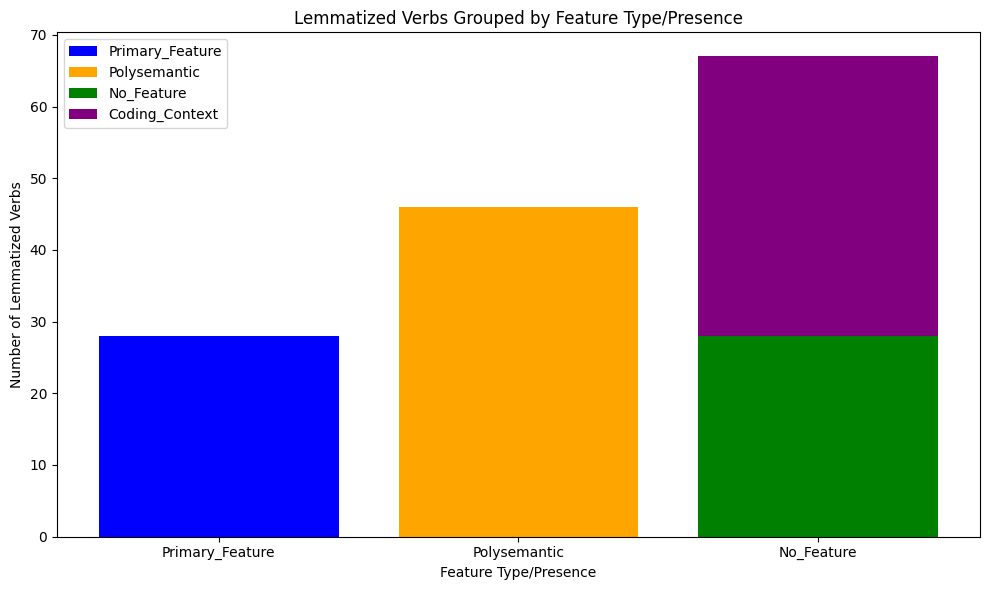

In [18]:
#@title Plot lemmatized verbs in VPN clauses in filtered dataset (colored by feature presence and type)

import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from collections import Counter

import nltk
nltk.download('wordnet')


df = pd.read_csv("/content/VPN_Feature_Data/all_verbs.csv", names=["verbs", "feat_or_ord", "optional_feat"], header=None)

lemmatizer = WordNetLemmatizer()
lemmatized_verbs = [lemmatizer.lemmatize(verb, pos='v') for verb in df['verbs']]
lemmatized_verb_counts = Counter(lemmatized_verbs)
categories = {}

for index, row in df.iterrows():
    verb = row['verbs']
    lemmatized_verb = lemmatizer.lemmatize(verb, pos='v')
    primary_feat = row['feat_or_ord'] > 0
    secondary_feat = not pd.isna(row['optional_feat'])
    no_feat = not primary_feat and not secondary_feat
    coding_context = row['feat_or_ord'] == -1

    if lemmatized_verb not in categories:
        if primary_feat:
            categories[lemmatized_verb] = ["Primary_Feature"]
        elif secondary_feat:
            categories[lemmatized_verb] = ["Polysemantic"]
        elif coding_context:
            categories[lemmatized_verb] = ["Coding_Context"]
        else:
            categories[lemmatized_verb] = ["No_Feature"]
    else:

        if primary_feat and "Primary_Feature" not in categories[lemmatized_verb]:
            categories[lemmatized_verb].append("Primary_Feature")
        if secondary_feat and "Polysemantic" not in categories[lemmatized_verb]:
            categories[lemmatized_verb].append("Polysemantic")
        if coding_context and "Coding_Context" not in categories[lemmatized_verb]:
            categories[lemmatized_verb].append("Coding_Context")

category_counts = {
    "Primary_Feature": 0,
    "Polysemantic": 0,
    "No_Feature": 0,
    "Coding_Context": 0
}

for verb, cat_list in categories.items():
    if "Primary_Feature" in cat_list:
        category_counts["Primary_Feature"] += 1
    elif "Polysemantic" in cat_list:
        category_counts["Polysemantic"] += 1
    else:
      if "No_Feature" in cat_list and "Coding_Context" not in cat_list:
          category_counts["No_Feature"] += 1
      elif "Coding_Context" in cat_list:
          category_counts["Coding_Context"] += 1


fig, ax = plt.subplots(figsize=(10, 6))
labels = ["Primary_Feature", "Polysemantic", "No_Feature"]
primary_feature_count = category_counts["Primary_Feature"]
polysemantic_count = category_counts["Polysemantic"]
no_feature_count = category_counts["No_Feature"]

coding_context_count = category_counts["Coding_Context"]

height_no_feature = no_feature_count - coding_context_count
height_coding_context = coding_context_count

ax.bar(labels[0], primary_feature_count, color='blue', label='Primary_Feature')
ax.bar(labels[1], polysemantic_count, color='orange', label='Polysemantic')
ax.bar(labels[2], height_no_feature, color='green', label='No_Feature')
ax.bar(labels[2], height_coding_context, bottom=height_no_feature, color='purple', label='Coding_Context')

ax.set_xlabel("Feature Type/Presence")
ax.set_ylabel("Number of Lemmatized Verbs")
ax.set_title("Lemmatized Verbs Grouped by Feature Type/Presence")

ax.legend()

plt.tight_layout()
plt.show()

In contrast with the the graph above, for the verb frequency vs.feature type scatter plot, I decided to leave all conjugations for each verb. I wanted to show the raw frequency of each verb/verb tense **in the context of the prepositional noun phrases**  present in the filtered-for-grammar dataset.

With this approach, it's apparent that many of the most frequent verbs with primary features have nearby conjugations in the frequency distribution.

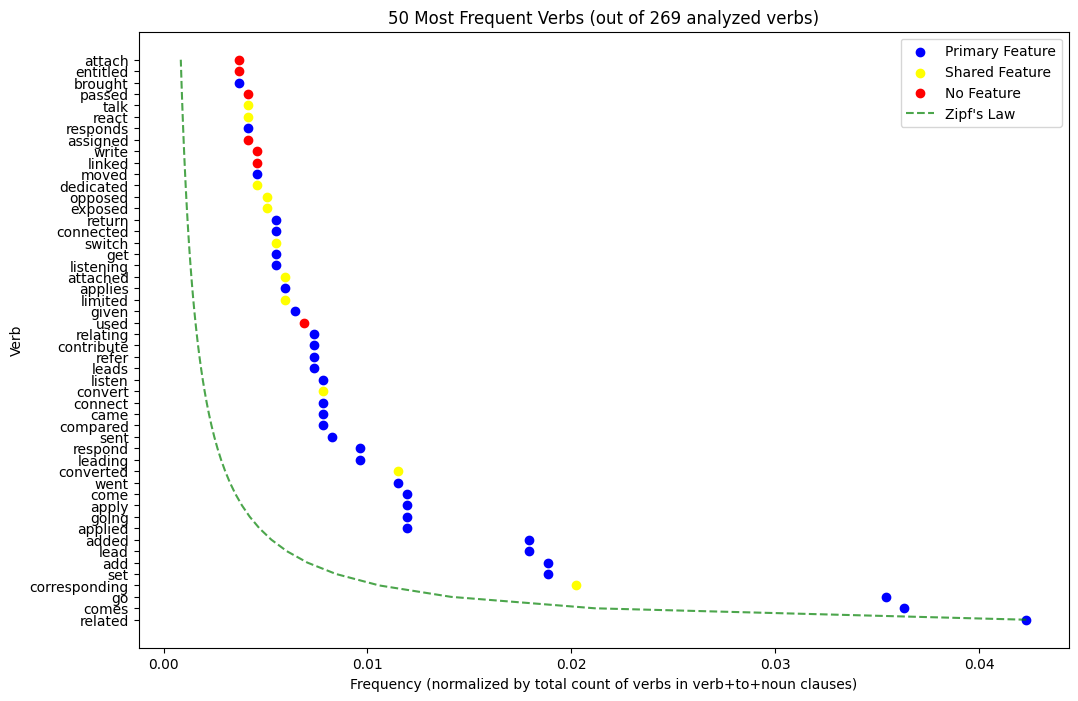

In [19]:
#@title Plot verb Frequency in filtered dataset (colored by feature presence)
import matplotlib.pyplot as plt

df = pd.read_csv("/content/VPN_Feature_Data/all_verbs.csv", names=["verbs", "feat_or_ord", "optional_feat"], header=None)

normalized_verb_counts = {}
verb_counts = Counter()

for index, st_data in enumerate(tokenized_data_preprocesses["matched_tokens"]):
  phrase_split = st_data[0]["phrase"].split(" ")
  if len(phrase_split[0]) == 0:
    verb_counts[phrase_split[1]] += 1
  else:
    verb_counts[phrase_split[0]] += 1

total_verb_count = sum(verb_counts.values())
for index, row in df.iterrows():
    verb = row['verbs']
    primary_feat = row['feat_or_ord'] > 0
    secondary_feat =  not pd.isna(row['optional_feat'])
    no_feat = not primary_feat and not secondary_feat
    if primary_feat:
        color = 'blue'
    elif no_feat:
        color = 'red'
    else:
        color = 'yellow'
    count = verb_counts.get(verb, 0)
    assert count > 0, f"{verb} not present"
    normalized_verb_counts[verb] = [count / total_verb_count, color]


sorted_top_50 = sorted(normalized_verb_counts.items(), key=lambda item: item[1][0], reverse=True)[:50]
all_verbs = np.array([verb for verb, _ in sorted_top_50])
verb_frequencies = np.array([count[0] for _, count in sorted_top_50])

colors = np.array([color[1] for _, color in sorted_top_50])
color_dict = {'blue': 'Primary Feature', 'red': 'No Feature', 'yellow': 'Shared Feature'}
categories = np.array([color_dict[color] for color in colors])


plt.figure(figsize=(12, 8))

y_positions = np.arange(len(all_verbs))


for color, category in set(color_dict.items()):
    mask = categories == category
    filtered_frequencies = verb_frequencies[mask]
    filtered_y_positions = y_positions[mask]

    plt.scatter(filtered_frequencies, filtered_y_positions, color=color,
                label=category)

plt.yticks(y_positions, all_verbs)

plt.yticks(y_positions, all_verbs)

plt.xlabel("Frequency (normalized by total count of verbs in verb+to+noun clauses)")
plt.ylabel("Verb")
plt.title("50 Most Frequent Verbs (out of 269 analyzed verbs)")

# Plot Zipf curve as a line
zipf_ranks = np.arange(1, len(sorted_top_50) + 1)
zipf_curve = [verb_frequencies[0] / rank for rank in zipf_ranks]
plt.plot(zipf_curve, np.array(all_verbs), color='green', linestyle='--', label="Zipf's Law", alpha=0.7)

plt.legend()
plt.show()

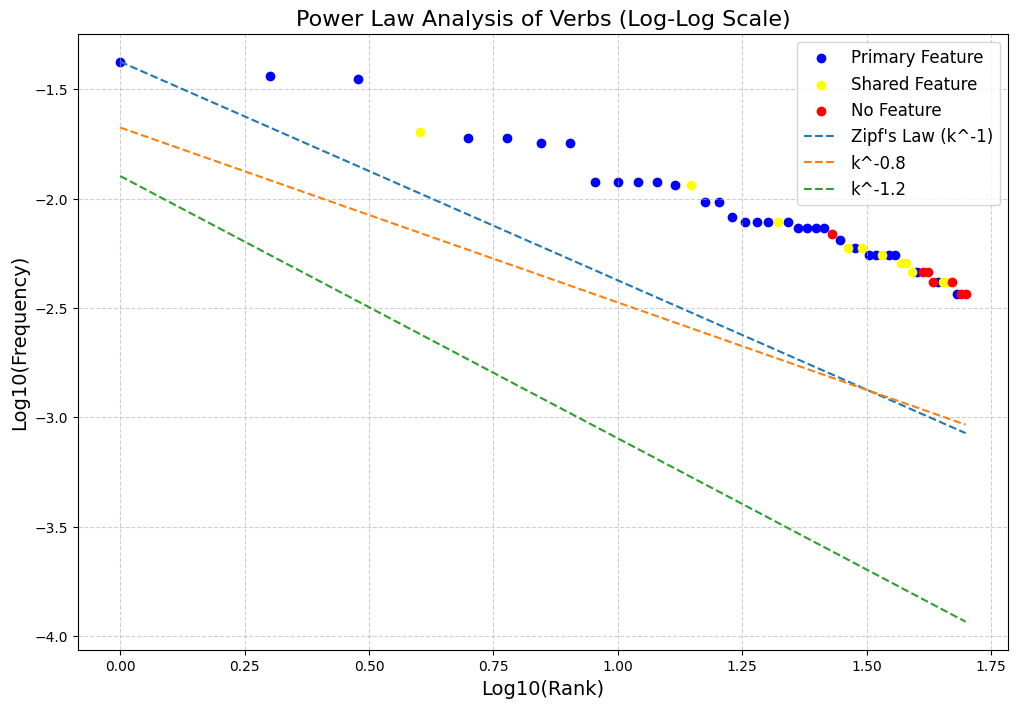

In [20]:
#@title Log plot to test power law relationship

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# load feature data
df = pd.read_csv("/content/VPN_Feature_Data/all_verbs.csv", names=["verbs", "feat_or_ord", "optional_feat"], header=None)

normalized_verb_counts = {}
verb_counts = Counter()

for index, st_data in enumerate(tokenized_data_preprocesses["matched_tokens"]):
  phrase_split = st_data[0]["phrase"].split(" ")
  if len(phrase_split[0]) == 0:
    verb_counts[phrase_split[1]] += 1
  else:
    verb_counts[phrase_split[0]] += 1

total_verb_count = sum(verb_counts.values())

for index, row in df.iterrows():
    verb = row['verbs']
    primary_feat = row['feat_or_ord'] > 0
    secondary_feat =  not pd.isna(row['optional_feat'])
    no_feat = not primary_feat and not secondary_feat
    if primary_feat:
        color = 'blue'
    elif no_feat:
        color = 'red'
    else:
        color = 'yellow'
    count = verb_counts.get(verb, 0)
    assert count > 0, f"{verb} not present"
    normalized_verb_counts[verb] = [count / total_verb_count, color]


sorted_top_50 = sorted(normalized_verb_counts.items(), key=lambda item: item[1][0], reverse=True)[:50]
all_verbs = np.array([verb for verb, _ in sorted_top_50])
verb_frequencies = np.array([count[0] for _, count in sorted_top_50])

colors = np.array([color[1] for _, color in sorted_top_50])
color_dict = {'blue': 'Primary Feature', 'red': 'No Feature', 'yellow': 'Shared Feature'}
categories = np.array([color_dict[color] for color in colors])


plt.figure(figsize=(12, 8))

for color, category in set(color_dict.items()):
    mask = categories == category
    filtered_frequencies = verb_frequencies[mask]
    filtered_ranks = np.arange(1, len(verb_frequencies) + 1)[mask]

    plt.scatter(
        np.log10(filtered_ranks),
        np.log10(filtered_frequencies),
        color=color,
        label=category
    )



# Power law examples
ranks = np.arange(1, len(verb_frequencies) + 1, dtype=float)

power_law_params = [
    (verb_frequencies[0], -1, "Zipf's Law (k^-1)"),
    (verb_frequencies[0] * 0.5, -0.8, "k^-0.8"),
    (verb_frequencies[0] * 0.3, -1.2, "k^-1.2")
]

for constant, exponent, label in power_law_params:
    theoretical_curve = constant * ranks**exponent
    plt.plot(
        np.log10(ranks),
        np.log10(theoretical_curve),
        linestyle="--",
        label=label
    )


plt.xlabel("Log10(Rank)", fontsize=14)
plt.ylabel("Log10(Frequency)", fontsize=14)
plt.title("Power Law Analysis of Verbs (Log-Log Scale)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

# Fearure Analysis: ' listen' Feature (idx 274)

First, let's confirm that the feature discovery method finds feature 274 for a relevant ' listen' clause.

In [10]:
tokens, substring_data = tokenized_data_preprocesses["tokens"][786] , tokenized_data_preprocesses["matched_tokens"][786]
print(substring_data[0])
substring_data[0]["phrase"], len_verb = strip_verb(substring_data[0]["phrase"])
substring_data[0]["pointers"] = [[start+len_verb+len('<|BOS|> '), end] for start, end in substring_data[0]["pointers"]]
res = get_act_diff_for_substring(encoder, model, tokens, substring_data[0])
print(f"discovered features: {res['feature_list']}")

{'phrase': ' listen to music', 'pointers': tensor([[307, 323]])}
discovered features: [274, 1144]


Following the lead of Kissane et al., I plot the Direct Feature Attribution distribution across attentions heads and using the Direct Feature Attribution per source position, I find which source tokens the top feature-274-activeated destination tokens attend back to.

In [11]:
#@title DFA functions


# Adapted from https://github.com/ckkissane/attention-output-saes/blob/03b2bc22c225529e81698b172154a3bc0427c6b0/common/utils.py#L639

def k_largest_indices(
    x,
    k,
    largest= True,
):
    '''
    Given a 2D array, returns the indices of the top or bottom `k` elements.
    '''
    indices = x.flatten().topk(k=k, largest=largest).indices
    rows = indices // x.size(1)
    cols = indices % x.size(1)
    return torch.stack((rows, cols), dim=1)

@torch.inference_mode()
def get_max_token_acts(
    encoder: AutoEncoder,
    model: HookedTransformer,
    tokens: Int[Tensor, "batch seq"],
    feature_idx: Union[int, List[int]],
    max_batch_size: Optional[int] = None,
    n_groups: int = 10,
    first_group_size: int = 20,
    other_groups_size: int = 5,
    verbose: bool = False,

) -> Dict[int, FeatureData]:
    '''
    Gets data that will be used to create the sequences in the HTML visualisation.

    Args:
        feature_idx: int
            The identity of the feature we're looking at (i.e. we slice the weights of the encoder). A list of
            features is accepted (the result will be a list of FeatureData objects).
        max_batch_size: Optional[int]
            Optionally used to chunk the tokens, if it's a large batch

        buffer: Tuple[int, int]
            The number of tokens on either side of the feature, for the right-hand visualisation.

    Returns list of dictionaries that contain SequenceBatchData for each feature (see that class's docstring for more info).
    '''
    model.reset_hooks(including_permanent=True)

    # Make feature_idx a list, for convenience
    if isinstance(feature_idx, int): feature_idx = [feature_idx]
    n_feats = len(feature_idx)

    # Chunk the tokens, for less memory usage
    tokens = tokens.unsqueeze(0) if len(tokens.shape) == 1 else tokens
    all_tokens = (tokens,) if max_batch_size is None else tokens.split(max_batch_size)
    all_tokens = [tok.to(device) for tok in all_tokens]

    # Create lists to store data, which we'll eventually concatenate
    all_feat_acts = []

    # Get encoder & decoder directions
    feature_act_dir = encoder.W_enc[:, feature_idx] # (d_mlp, feats)
    feature_bias = encoder.b_enc[feature_idx] # (feats,)
    #assert feature_act_dir.T.shape == feature_out_dir.shape #== (len(feature_idx), encoder.cfg.d_mlp)

    # ! Define hook function to perform feature ablation
    def hook_fn_act_post(act: Float[Tensor, "batch seq act_size"], hook: HookPoint):
        '''
        Encoder has learned x^j \approx b + \sum_i f_i(x^j)d_i where:
            - f_i are the feature activations
            - d_i are the feature output directions

        This hook function stores all the information we'll need later on. It doesn't actually perform feature ablation, because
        if we did this, then we'd have to run a different fwd pass for every feature, which is super wasteful! But later, we'll
        calculate the effect of feature ablation,  i.e. x^j <- x^j - f_i(x^j)d_i for i = feature_idx, only on the tokens we care
        about (the ones which will appear in the visualisation).
        '''
        if encoder.cfg["concat_heads"]:
            act = einops.rearrange(
                act, "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
        x_cent = act - encoder.b_dec
        feat_acts_pre = einops.einsum(x_cent, feature_act_dir, "batch seq act_size, act_size feats -> batch seq feats")
        feat_acts = F.relu(feat_acts_pre + feature_bias)
        all_feat_acts.append(feat_acts)

    # ! Run the forward passes (triggering the hooks), concat all results

    # Run the model without hook (to store all the information we need, not to actually return anything)
    for _tokens in all_tokens:
        model.run_with_hooks(_tokens, return_type=None, fwd_hooks=[
            (encoder.cfg["act_name"], hook_fn_act_post),
        ])

    # Stack the results, and check shapes
    feat_acts = torch.concatenate(all_feat_acts) # [batch seq feats]
    assert feat_acts[:, :-1].shape == tokens[:, :-1].shape + (len(feature_idx),)

    max_data_list = []

    iterator = range(n_feats) if not(verbose) else tqdm(range(n_feats), desc="Getting sequence data", leave=False)

    for feat in iterator:

        _feat_acts = feat_acts[..., feat] # [batch seq]
        top_k = k_largest_indices(_feat_acts, k=first_group_size, largest=True)
        max_data_list.append(top_k)

    return torch.concatenate(max_data_list)

def dfa_all_heads(model, tokens, feature_id, encoder):
    _, cache = model.run_with_cache(tokens)
    d_head = model.cfg.d_head
    n_head = model.cfg.n_heads
    layer = encoder.cfg["layer"]
    z = cache["z", layer] # [batch, seq, n_head, d_head]
    assert z.shape[-1] == model.cfg.d_head
    #z_cat = einops.rearrange(z, "batch seq d_model -> batch seq n_head d_head", d_head=d_head) # [batch, seq, n_heads*d_head]
    enc = einops.rearrange(encoder.W_enc[:, feature_id], "(n_head d_head) -> n_head d_head", n_head=n_head, d_head=d_head)
    dfa = einops.einsum(
        z, enc,
        "batch seq n_head d_head, n_head d_head -> batch seq n_head",
    )
    return dfa

# From https://github.com/ckkissane/attention-output-saes/blob/03b2bc22c225529e81698b172154a3bc0427c6b0/common/utils.py#L639

def get_per_src_pos_dfa_all_heads(tokens, feature_id, encoder, model):
    _, cache = model.run_with_cache(tokens)
    layer = encoder.cfg["layer"]
    v = cache["v", layer] # [batch, src_pos, n_heads, d_head]
    v_cat = einops.rearrange(v, "batch src_pos n_heads d_head -> batch src_pos (n_heads d_head)") # [batch, src_pos, n_heads*d_head]

    attn_weights = cache['pattern', layer]  # [batch, n_heads, dest_pos, src_pos]
    attn_weights_bcast = einops.repeat(attn_weights, "batch n_heads dest_pos src_pos -> batch dest_pos src_pos (n_heads d_head)", d_head=model.cfg.d_head)  # [batch, dest_pos, src_pos, n_heads*d_head]

    # Element-wise multiplication, removing the loop
    decomposed_z_cat = attn_weights_bcast * v_cat.unsqueeze(1)  # [batch, dest_pos, src_pos n_heads*d_head]

    per_src_pos_dfa = einops.einsum(
        decomposed_z_cat, encoder.W_enc[:, feature_id],
        "batch dest_pos src_pos d_model, d_model -> batch dest_pos src_pos",
    )
    return per_src_pos_dfa


I calculate DFA following in Kissane et al.'s methodology. Similar to the distribution they found for the 'With' token, multiple heads appear to be important for the 'listen' feature 274.

**CAVEAT**: I don't want to draw too many conclusions from this plot because I'm only using the first 1,000 records (compute restricted); the DFA by source position calculation below uses 6,000 records, and I noticed that as I added records the results converged around the expected behavior (attending to the expected clauses), whereas the results with less data were noisier, with non linguistic, code symbols returning as top firings. I suspect that if I required an activation threshold these examples would not have come through.



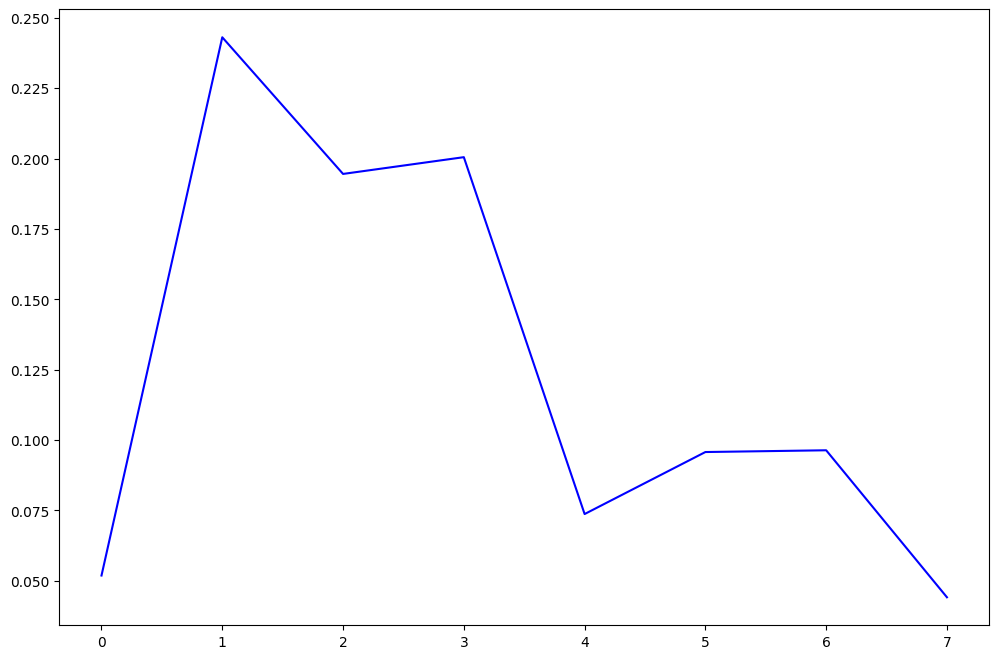

In [12]:
#@title DFA for feature 274 for first 1000 records of the original dataset (not filtered for the grammar)
dfa = dfa_all_heads(model, all_tokens[:1000], 274, encoder)

head_sums = torch.sum(dfa ** 2, dim=(0, 1))
total_sum = torch.sum(head_sums)
head_contributions = head_sums / total_sum

plt.figure(figsize=(12, 8))
y_positions = np.arange(len(head_contributions))
plt.plot(y_positions,head_contributions.cpu().tolist(), color='blue')
plt.show()


Calculating the per source position DFA and displaying the top three highest activated source positions for the ten highest-activated destination tokens. The destination tokens tend to be nouns, noun modifiers/articles and the 'to' preposition in the clause. I hypothesize that the full nounal phrases would make up the other top destination tokens in each text.

In [13]:
#@title Calculating the per source position DFA
max_token_inds = get_max_token_acts(encoder, model, all_tokens[:6000], 274, first_group_size=10)
all_tokens = all_tokens.cuda()
max_token_acts = all_tokens[:6000][max_token_inds[:, 0]]
per_src_dfa = get_per_src_pos_dfa_all_heads(max_token_acts, 274, encoder, model) # [batch, dest_pos, src_pos]
batch_indices = torch.arange(max_token_acts.shape[0])
per_src_dfa = per_src_dfa[batch_indices, max_token_inds[:, 1], :]  # [batch, src_pos]
per_src_dfa[:, 0] = 0
vals, max_inds = torch.topk(per_src_dfa, k=3, dim=1, largest=True)

In [14]:
#@title Plotting the per source position DFA
import pandas as pd
import plotly.graph_objects as go

table_data = []

for batch, max_ind in enumerate(max_inds):
    maxes = max_token_acts[batch, max_ind]
    source_words = model.tokenizer.decode(maxes)
    destination_word = model.tokenizer.decode(all_tokens[:6000][max_token_inds[batch, 0], max_token_inds[batch, 1]])

    table_data.append([source_words, destination_word])

df = pd.DataFrame(table_data, columns=["Top 3 Source Words", "Destination Word"])

fig = go.Figure(go.Table(
    header=dict(values=["Top 3 Source Words", "Destination Word"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df['Top 3 Source Words'], df['Destination Word']],
               fill_color='lavender',
               align='left'))
)

fig.show()

# Next Steps

There are several directions in which this research could go:
1. Exploring the relationship between skill (prepositional noun clause tracking for verbs) and data/model scale. This was done for a two layer Transformer model, trained on 20% code. Would there be more primary features for each verb in bigger models trained on more data?
2. It appears that the nouns in the clauses attend back to the verb and the preposition, testing how the feature's top activations change when adding noise to the noun (destination) token's embedding, or how it changes when adding noise to the top source position embeddings.
3. There appears to be so many different 'to' features; it might be worth while to see how/if they step in when ablating primary feature.
4. Bigger picture circuit discovery for these clauses. I noted above that I often found similar features which fire on the verb in addition to the rest of the clause. Seeing if/how these features interact, and also exploring downstream MLP interactions might be interesting.